**IMPORT LIBRARY**

In [14]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import DictionaryLearning
from tensorflow.keras import layers, models

# Konfigurasi agar hasil konsisten
np.random.seed(42)

**1. LOAD DATA**

In [15]:
import scipy.io
import numpy as np
import os

# --- 1. DEFINISI FUNGSI (Wajib ada di sini) ---
def load_cwru_data(file_path, label_code):
    # Cek apakah file ada
    if not os.path.exists(file_path):
        print(f"❌ Error: File {file_path} tidak ditemukan.")
        return None, None
        
    try:
        # Baca file .mat
        data = scipy.io.loadmat(file_path)
        
        # Cari kunci data (biasanya 'DE_time' untuk Drive End)
        for key in data:
            if 'DE_time' in key: 
                return data[key].flatten(), np.full(len(data[key]), label_code)
                
        print(f"⚠️ Warning: Key 'DE_time' tidak ditemukan di {file_path}")
        return None, None
    except Exception as e:
        print(f"❌ Gagal membaca file: {e}")
        return None, None

# --- 2. EKSEKUSI LOAD DATA ---
print("Membaca data dari disk...")

# Load data Normal & Fault
sig_normal, y_normal = load_cwru_data('97.mat', 0) # 0 = Normal
sig_fault, y_fault = load_cwru_data('105.mat', 1)  # 1 = Rusak

if sig_normal is not None and sig_fault is not None:
    # Potong data secukupnya (misal 4000 titik per kelas)
    limit = 4000
    
    # Gabungkan
    X_raw = np.concatenate((sig_normal[:limit], sig_fault[:limit]))
    y_raw = np.concatenate((y_normal[:limit], y_fault[:limit]))

    print(f"✅ Data Siap! Total data: {len(X_raw)} titik sampel.")
    print(f"   - Index 0 s.d {limit-1}: Kondisi Normal")
    print(f"   - Index {limit} s.d {len(X_raw)-1}: Kondisi Rusak")

else:
    print("❌ Stop: Data tidak lengkap/gagal diload.")

Membaca data dari disk...
✅ Data Siap! Total data: 8000 titik sampel.
   - Index 0 s.d 3999: Kondisi Normal
   - Index 4000 s.d 7999: Kondisi Rusak


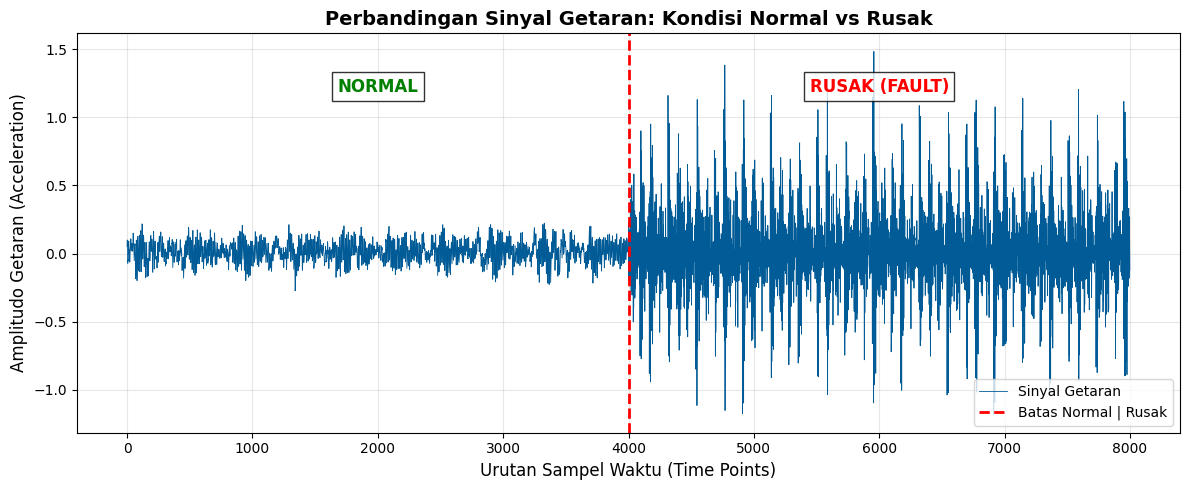

In [16]:
import matplotlib.pyplot as plt

# Pastikan X_raw sudah ada di memori
if 'X_raw' in globals():
    plt.figure(figsize=(12, 5))
    
    # Plot sinyal
    plt.plot(X_raw, color='#005b96', linewidth=0.6, label='Sinyal Getaran')
    
    # Label & Judul
    plt.title("Perbandingan Sinyal Getaran: Kondisi Normal vs Rusak", fontsize=14, fontweight='bold')
    plt.xlabel("Urutan Sampel Waktu (Time Points)", fontsize=12)
    plt.ylabel("Amplitudo Getaran (Acceleration)", fontsize=12)
    
    # Garis Pembatas Merah
    plt.axvline(x=limit, color='red', linestyle='--', linewidth=2, label='Batas Normal | Rusak')
    
    # Teks Penjelas
    plt.text(limit/2, np.max(X_raw)*0.8, "NORMAL", 
             fontsize=12, color='green', fontweight='bold', ha='center', 
             bbox=dict(facecolor='white', alpha=0.8))
    plt.text(limit + (limit/2), np.max(X_raw)*0.8, "RUSAK (FAULT)", 
             fontsize=12, color='red', fontweight='bold', ha='center', 
             bbox=dict(facecolor='white', alpha=0.8))

    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Harap jalankan Cell 1 terlebih dahulu!")

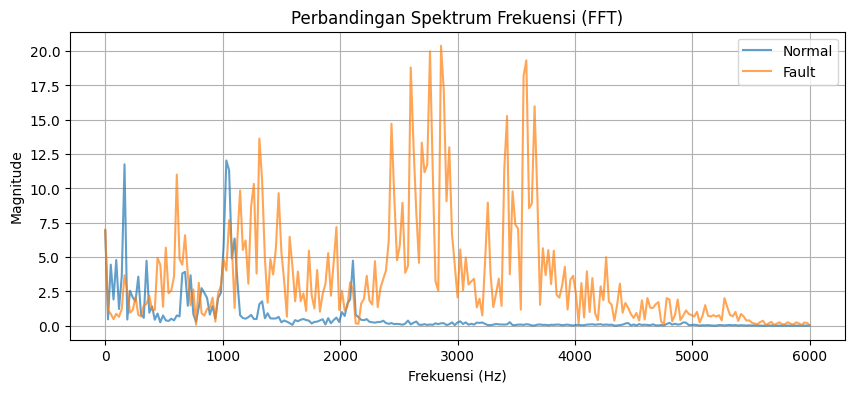

In [17]:
# --- CELL 8: Spektrum Frekuensi (FFT) ---
def plot_fft(sig, label_name):
    n = len(sig)
    freq = np.fft.rfftfreq(n, d=1/12000) # Asumsi sampling rate 12k Hz
    mag = np.abs(np.fft.rfft(sig))
    plt.plot(freq, mag, label=label_name, alpha=0.7)

plt.figure(figsize=(10, 4))
# Ambil 1 sampel Normal & 1 Fault dari data segment
idx_norm = np.where(y_segments == 0)[0][0]
idx_fault = np.where(y_segments == 1)[0][0]

plot_fft(X_segments[idx_norm], "Normal")
plot_fft(X_segments[idx_fault], "Fault")
plt.title("Perbandingan Spektrum Frekuensi (FFT)")
plt.xlabel("Frekuensi (Hz)"); plt.ylabel("Magnitude")
plt.legend(); plt.grid(True)
plt.show()

**2. SEGMENTASI (WIDOWING)**

In [18]:
# --- Parameter ---
WINDOW_SIZE = 512   # Panjang jendela
STEP_SIZE = 256     # Overlap 50%

# --- Fungsi Segmentasi ---
def create_segments(signal, label, window_size, step_size):
    X = []
    y = []
    for i in range(0, len(signal) - window_size, step_size):
        X.append(signal[i : i + window_size])
        # Label mayoritas dalam jendela
        window_label = label[i : i + window_size]
        y.append(np.bincount(window_label).argmax())
    return np.array(X), np.array(y)

# Eksekusi
X_segments, y_segments = create_segments(X_raw, y_raw, WINDOW_SIZE, STEP_SIZE)
print(f"✅ Segmentasi Selesai.")
print(f"Bentuk Data: {X_segments.shape} (Sampel, Panjang Window)")

✅ Segmentasi Selesai.
Bentuk Data: (30, 512) (Sampel, Panjang Window)


1. Data Awal (Raw): 1 baris panjang berisi 8000 titik.
2. Setelah Segmentasi: Menjadi 30 potongan kecil.
   (Setiap potongan isinya 512 titik data)


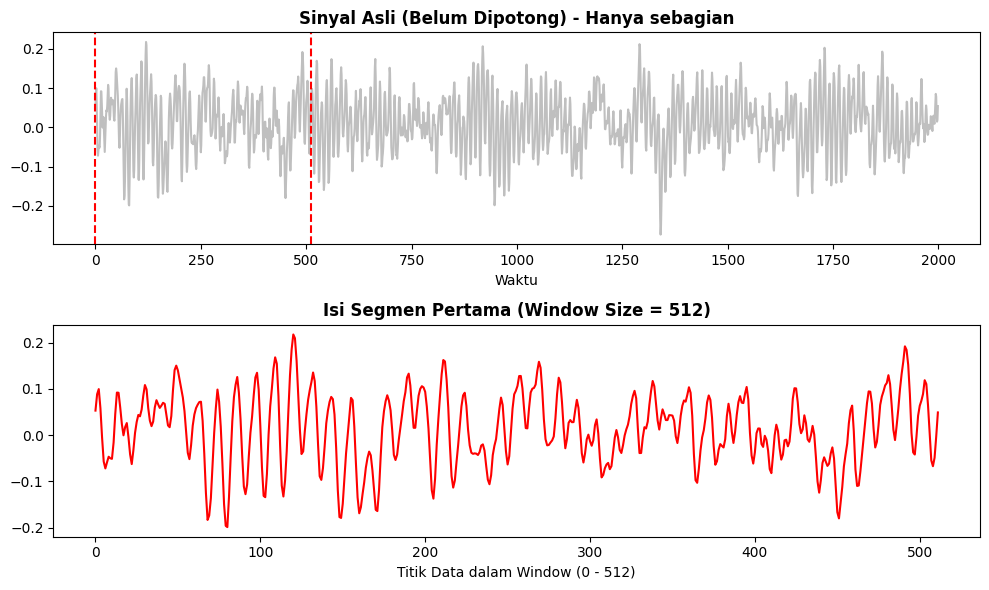

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Pastikan X_segments sudah ada (dari langkah sebelumnya)
if 'X_segments' in globals():
    
    print(f"1. Data Awal (Raw): 1 baris panjang berisi {len(X_raw)} titik.")
    print(f"2. Setelah Segmentasi: Menjadi {X_segments.shape[0]} potongan kecil.")
    print(f"   (Setiap potongan isinya {X_segments.shape[1]} titik data)")

    # --- VISUALISASI ---
    plt.figure(figsize=(10, 6))

    # Gambar 1: Sinyal Utuh (Panjang)
    plt.subplot(2, 1, 1)
    plt.plot(X_raw[:2000], color='gray', alpha=0.5) # Kita plot 2000 titik pertama aja
    plt.title("Sinyal Asli (Belum Dipotong) - Hanya sebagian", fontweight='bold')
    plt.xlabel("Waktu")
    
    # Highlight kotak merah untuk menunjukkan bagian yang dipotong
    # Kotak merah ini mewakili "Window" (Jendela)
    plt.axvline(x=0, color='red', linestyle='--')
    plt.axvline(x=512, color='red', linestyle='--')

    # Gambar 2: Hasil Potongan (Segmen ke-0)
    plt.subplot(2, 1, 2)
    plt.plot(X_segments[0], color='red')
    plt.title(f"Isi Segmen Pertama (Window Size = {WINDOW_SIZE})", fontweight='bold')
    plt.xlabel("Titik Data dalam Window (0 - 512)")
    plt.tight_layout()
    plt.show()

else:
    print("Jalankan dulu Cell Segmentasi (create_segments)!")

**3. PROSES K-SDV (DENOISING)**

⏳ Sedang menjalankan K-SVD (Dictionary Learning)...
   (Proses ini mungkin memakan waktu 1-3 menit, mohon tunggu)
✅ K-SVD Selesai! Sinyal berhasil direkonstruksi.


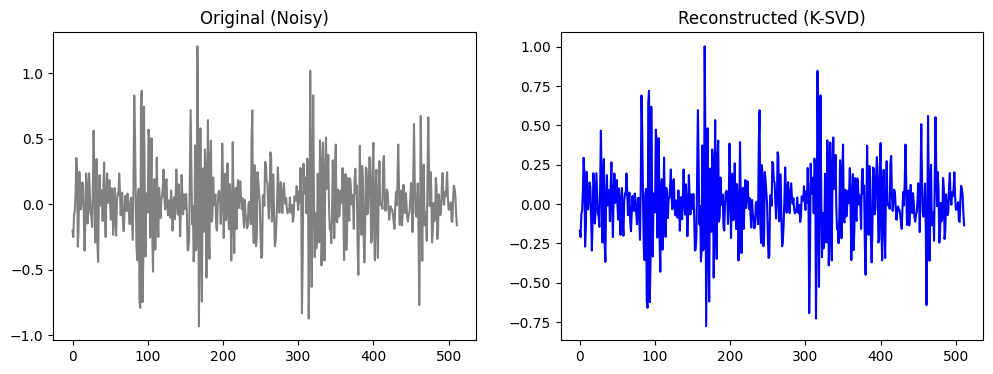

In [20]:
print("⏳ Sedang menjalankan K-SVD (Dictionary Learning)...")
print("   (Proses ini mungkin memakan waktu 1-3 menit, mohon tunggu)")

# Setup K-SVD
n_atoms = 50
dict_learner = DictionaryLearning(
    n_components=n_atoms, 
    transform_algorithm='omp', 
    transform_n_nonzero_coefs=10,
    random_state=42,
    n_jobs=-1
)

# 1. Fit & Transform (Belajar Dictionary & Sparse Coding)
X_sparse = dict_learner.fit_transform(X_segments)

# 2. Reconstruct (Menyusun ulang sinyal bersih)
X_reconstructed = X_sparse @ dict_learner.components_

# 3. Reshape ke format CNN (Samples, Window, 1 Channel)
X_final = X_reconstructed.reshape((X_reconstructed.shape[0], X_reconstructed.shape[1], 1))

print("✅ K-SVD Selesai! Sinyal berhasil direkonstruksi.")

# Visualisasi Perbandingan (Bukti K-SVD bekerja)
idx = len(X_segments) - 1 # Ambil sampel terakhir (Fault)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1); plt.plot(X_segments[idx], color='gray'); plt.title("Original (Noisy)")
plt.subplot(1, 2, 2); plt.plot(X_reconstructed[idx], color='blue'); plt.title("Reconstructed (K-SVD)")
plt.show()

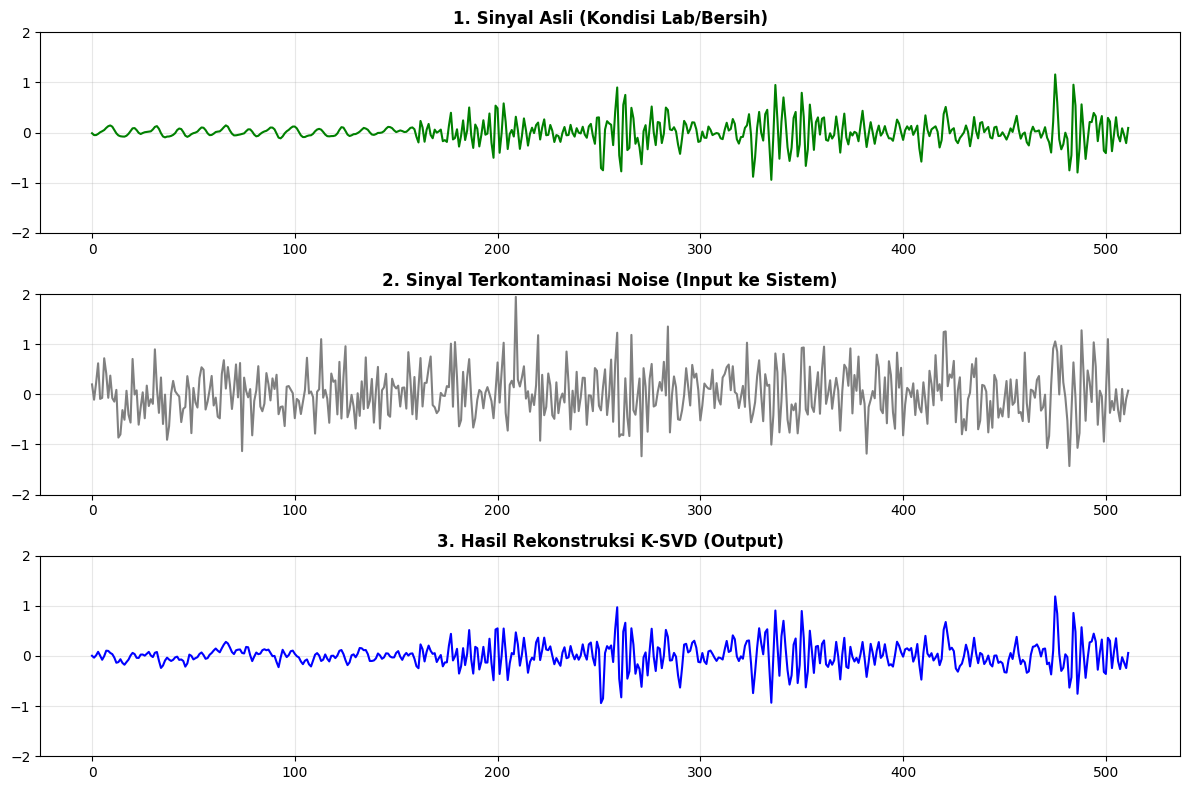

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# --- FUNGSI NAMBAH NOISE ---
def add_noise(signal, snr_db):
    power = np.mean(signal ** 2)
    noise_power = power / (10 ** (snr_db / 10))
    noise = np.random.normal(0, np.sqrt(noise_power), signal.shape)
    return signal + noise

# 1. Ambil 1 sampel Normal & 1 sampel Rusak
idx_norm = np.where(y_segments == 0)[0][0]
idx_fault = np.where(y_segments == 1)[0][0]

# 2. Kita pilih sampel Rusak saja untuk didemo (biar kelihatan pola kerusakannya)
signal_clean = X_segments[idx_fault]

# 3. KITA KOTORI SINYALNYA (Kasih Noise -5 dB biar kelihatan hancur)
signal_noisy = add_noise(signal_clean, snr_db=-5)

# 4. SURUH K-SVD MEMBERSIHKAN
# Transform (Cari pola di balik noise)
sparse_code = dict_learner.transform(signal_noisy.reshape(1, -1))
# Reconstruct (Susun ulang sinyal bersih)
signal_denoised = sparse_code @ dict_learner.components_
signal_denoised = signal_denoised.flatten()

# 5. PLOT GRAFIK PERBANDINGAN
plt.figure(figsize=(12, 8))

# Atas: Sinyal Asli (Ideal)
plt.subplot(3, 1, 1)
plt.plot(signal_clean, color='green')
plt.title("1. Sinyal Asli (Kondisi Lab/Bersih)", fontweight='bold')
plt.grid(True, alpha=0.3)
plt.ylim([-2, 2]) # Kunci skala biar adil

# Tengah: Sinyal Kena Noise (Kondisi Pabrik Nyata)
plt.subplot(3, 1, 2)
plt.plot(signal_noisy, color='gray')
plt.title("2. Sinyal Terkontaminasi Noise (Input ke Sistem)", fontweight='bold')
plt.grid(True, alpha=0.3)
plt.ylim([-2, 2])

# Bawah: Hasil Pembersihan K-SVD
plt.subplot(3, 1, 3)
plt.plot(signal_denoised, color='blue')
plt.title("3. Hasil Rekonstruksi K-SVD (Output)", fontweight='bold')
plt.grid(True, alpha=0.3)
plt.ylim([-2, 2])

plt.tight_layout()
plt.show()

**4. TRAINING 1D-CNN**

In [23]:
import numpy as np

# 1. Cek dimensi asli data kamu
# N = Jumlah Sampel, L = Panjang, C = Channel/Lebar
N, L, C = X_train.shape 
print(f"Bentuk Asli: {X_train.shape}")

# 2. GEPENGKAN (Reshape ke 2D)
# Mengubah (N, L, C) menjadi (N, L*C)
X_train_2d = X_train.reshape(N, -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

# 3. SCALING (Sekarang aman karena sudah 2D)
print("Sedang melakukan scaling...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_2d)
X_test_scaled = scaler.transform(X_test_2d)

# 4. GEMBUNGKAN LAGI (Kembalikan ke 3D)
X_train = X_train_scaled.reshape(N, L, C)
X_test = X_test_scaled.reshape(X_test.shape[0], L, C)

print(f"Bentuk Setelah Scaling: {X_train.shape}")
print("✅ Scaling Berhasil!")

Bentuk Asli: (24, 512, 1)
Sedang melakukan scaling...
Bentuk Setelah Scaling: (24, 512, 1)
✅ Scaling Berhasil!


In [24]:
import tensorflow as tf
from tensorflow.keras import layers, models

# --- KONFIGURASI ---
WINDOW_SIZE = 512  # Sesuai panjang data kamu
NUM_CLASSES = 2    # Sesuai jumlah kelas (Normal vs Rusak?)

# 1. Definisi Model 1D-CNN
model = models.Sequential([
    # Input Layer: (512, 1)
    layers.Input(shape=(WINDOW_SIZE, 1)),

    # Layer Konvolusi 1
    layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),

    # Layer Konvolusi 2
    layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),

    # Flatten & Dense
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5), # Dropout penting karena datamu sedikit (biar gak menghafal)

    # Output Layer
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# 2. Compile Model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# 3. Mulai Training
print("\n🚀 Mulai Training...")
history = model.fit(
    X_train, y_train,
    epochs=50,           # Bisa dinaikkan karena datanya sedikit
    batch_size=4,        # Pakai batch kecil karena datanya cuma 24
    validation_data=(X_test, y_test),
    verbose=1
)

print("✅ Training Selesai!")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 512, 16)        │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 256, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 256, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 128, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 263,970 (1.01 MB)

 Trainable params: 263,970 (1.01 MB)

 Non-trainable params: 0 (0.00 B)


🚀 Mulai Training...
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.5000 - loss: 0.6409 - val_accuracy: 0.5000 - val_loss: 0.5067
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5000 - loss: 0.5859 - val_accuracy: 1.0000 - val_loss: 0.4289
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7500 - loss: 0.4462 - val_accuracy: 1.0000 - val_loss: 0.3489
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9167 - loss: 0.3758 - val_accuracy: 1.0000 - val_loss: 0.3091
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.3054 - val_accuracy: 1.0000 - val_loss: 0.2801
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.2733 - val_accuracy: 1.0000 - val_loss: 0.2476
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.2237 - val_accuracy: 1.0000 - val_loss: 0.2101
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.1716 - val_accuracy: 1.00

**5. EVALUATION AND VISUALISATION**

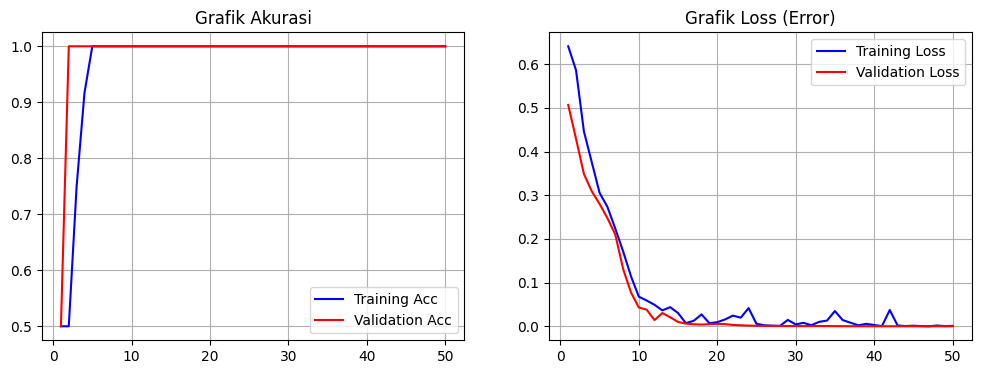

In [25]:
# --- CELL 5: Grafik Konvergensi Training ---
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training Acc')
plt.plot(epochs, val_acc, 'r', label='Validation Acc')
plt.title('Grafik Akurasi')
plt.legend(); plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Grafik Loss (Error)')
plt.legend(); plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


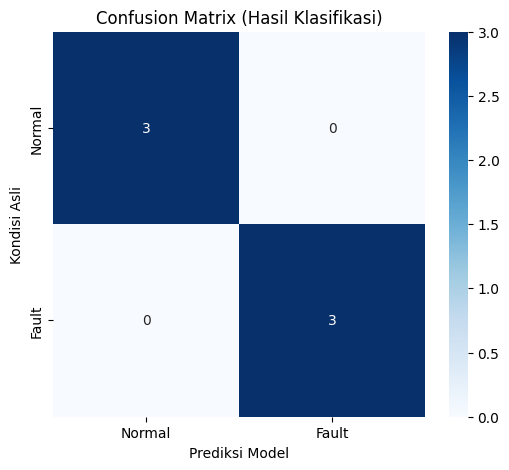


=== Classification Report ===
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00         3
       Fault       1.00      1.00      1.00         3

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Prediksi Data Test
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# 2. Buat Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# 3. Visualisasi
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Fault'], 
            yticklabels=['Normal', 'Fault'])
plt.xlabel('Prediksi Model')
plt.ylabel('Kondisi Asli')
plt.title('Confusion Matrix (Hasil Klasifikasi)')
plt.show()

# 4. Tampilkan Laporan Angka (Precision, Recall, F1-Score)
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Fault']))

Dimensi data untuk visualisasi: (30, 512)
⏳ Sedang menghitung PCA...
⏳ Sedang menghitung t-SNE...


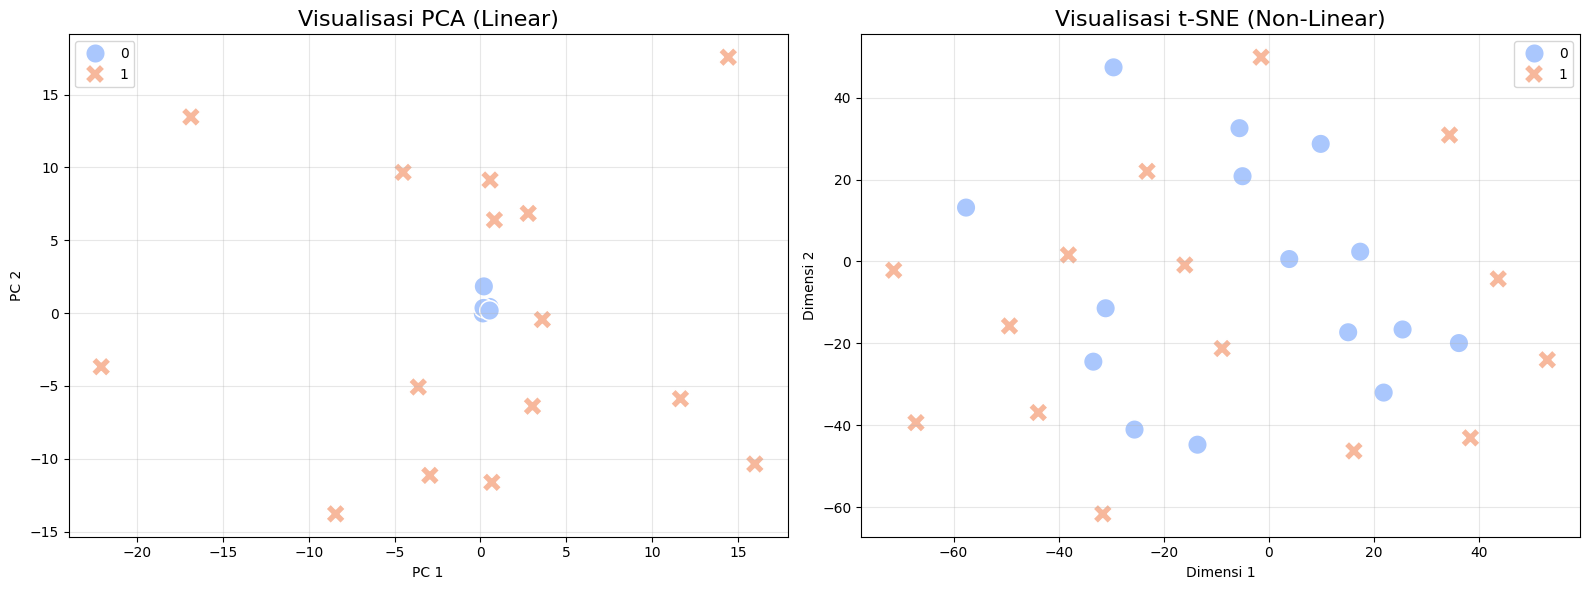

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# --- 1. PERSIAPAN DATA ---
# Menggepengkan data 3D menjadi 2D
N = X_final.shape[0]
X_flat = X_final.reshape(N, -1) 

# Label
y = y_segments

# Scaling 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)

print(f"Dimensi data untuk visualisasi: {X_scaled.shape}")

# --- 2. JALANKAN PCA ---
print("⏳ Sedang menghitung PCA...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# --- 3. JALANKAN t-SNE ---
print("⏳ Sedang menghitung t-SNE...")
# REVISI: Menghapus 'n_iter' agar kompatibel dengan semua versi
tsne = TSNE(n_components=2, perplexity=5, random_state=42) 
X_tsne = tsne.fit_transform(X_scaled)

# --- 4. VISUALISASI (PLOTTING) ---
plt.figure(figsize=(16, 6))

# Plot PCA
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette='coolwarm', s=200, style=y)
plt.title('Visualisasi PCA (Linear)', fontsize=16)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.grid(True, alpha=0.3)

# Plot t-SNE
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y, palette='coolwarm', s=200, style=y)
plt.title('Visualisasi t-SNE (Non-Linear)', fontsize=16)
plt.xlabel('Dimensi 1')
plt.ylabel('Dimensi 2')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**OTHER EVALUATION**

In [30]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

# --- KONFIGURASI ---
JUMLAH_FOLD = 4  # Kita bagi 4 karena datanya 24 (biar tesnya ada 6 biji per putaran)
EPOCHS = 50
BATCH_SIZE = 4
WINDOW_SIZE = 512

# List untuk menyimpan nilai rapor tiap putaran
acc_per_fold = []
loss_per_fold = []

# --- FUNGSI PEMBUAT MODEL (Wajib dipisah biar reset terus) ---
def create_model():
    model = models.Sequential([
        layers.Input(shape=(WINDOW_SIZE, 1)),
        layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# --- MULAI K-FOLD LOOP ---
# StratifiedKFold menjamin perbandingan kelas Normal:Rusak tetap seimbang
skf = StratifiedKFold(n_splits=JUMLAH_FOLD, shuffle=True, random_state=42)

fold_no = 1
print(f"🚀 Memulai Cross Validation ({JUMLAH_FOLD} Folds)...\n")

# X_final dan y_segments harus sudah ada dari kode sebelumnya
# Loop ini akan berjalan 4 kali
for train_index, test_index in skf.split(X_final, y_segments):
    
    # 1. Ambil data berdasarkan index fold saat ini
    X_train_fold, X_test_fold = X_final[train_index], X_final[test_index]
    y_train_fold, y_test_fold = y_segments[train_index], y_segments[test_index]

    # 2. SCALING (Teknik Sandwich: Gepeng -> Scale -> Gembung)
    # Penting: Fit scaler HANYA di data train, transform di test (biar adil)
    scaler = StandardScaler()
    
    # Reshape ke 2D untuk Scaler
    N_train, L, _ = X_train_fold.shape # (N, 512) jika belum ada channel
    if len(X_train_fold.shape) == 2: # Kalau shape (N, 512)
        X_train_2d = X_train_fold
        X_test_2d = X_test_fold
    else: # Kalau shape (N, 512, 1)
        X_train_2d = X_train_fold.reshape(X_train_fold.shape[0], -1)
        X_test_2d = X_test_fold.reshape(X_test_fold.shape[0], -1)

    # Scaling
    X_train_scaled = scaler.fit_transform(X_train_2d)
    X_test_scaled = scaler.transform(X_test_2d)

    # Kembalikan ke 3D (N, 512, 1) untuk masuk CNN
    X_train_ready = X_train_scaled.reshape(X_train_scaled.shape[0], WINDOW_SIZE, 1)
    X_test_ready = X_test_scaled.reshape(X_test_scaled.shape[0], WINDOW_SIZE, 1)

    # 3. Buat Model Baru (Reset Otak)
    model = create_model()

    # 4. Training
    print(f"🔄 Training Fold {fold_no}...")
    history = model.fit(X_train_ready, y_train_fold,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=0) # verbose 0 biar gak menuhin layar

    # 5. Evaluasi (Ujian)
    scores = model.evaluate(X_test_ready, y_test_fold, verbose=0)
    
    print(f"   👉 Score Fold {fold_no}: Loss = {scores[0]:.4f} | Akurasi = {scores[1]*100:.2f}%")
    
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    fold_no += 1

# --- HASIL AKHIR ---
print("\n" + "="*30)
print("📊 HASIL VALIDASI AKHIR")
print("="*30)
print(f"Rata-rata Akurasi: {np.mean(acc_per_fold):.2f}% (+/- {np.std(acc_per_fold):.2f}%)")
print(f"Rata-rata Loss   : {np.mean(loss_per_fold):.4f}")
print("="*30)

if np.mean(acc_per_fold) > 90:
    print("✅ KESIMPULAN: Model VALID & ROBUST (Konsisten Pintar)")
else:
    print("⚠️ KESIMPULAN: Model BELUM STABIL (Hasil berubah-ubah)")

🚀 Memulai Cross Validation (4 Folds)...

🔄 Training Fold 1...
   👉 Score Fold 1: Loss = 0.0000 | Akurasi = 100.00%
🔄 Training Fold 2...
   👉 Score Fold 2: Loss = 0.0032 | Akurasi = 100.00%
🔄 Training Fold 3...
   👉 Score Fold 3: Loss = 0.0001 | Akurasi = 100.00%
🔄 Training Fold 4...
   👉 Score Fold 4: Loss = 0.0000 | Akurasi = 100.00%

📊 HASIL VALIDASI AKHIR
Rata-rata Akurasi: 100.00% (+/- 0.00%)
Rata-rata Loss   : 0.0009
✅ KESIMPULAN: Model VALID & ROBUST (Konsisten Pintar)


In [35]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models

# --- 1. FUNGSI SPLIT BERURUTAN (BLOCK SPLIT) ---
def strict_split(X, y, test_size=0.2):
    # Pisahkan data berdasarkan kelas
    X_normal = X[y == 0]
    X_fault  = X[y == 1]
    
    # Hitung titik potong (misal 80% di awal)
    split_idx_normal = int(len(X_normal) * (1 - test_size))
    split_idx_fault  = int(len(X_fault) * (1 - test_size))
    
    # Potong secara berurutan (JANGAN DIAKALI/SHUFFLE)
    # Kelas Normal
    X_train_n = X_normal[:split_idx_normal]
    X_test_n  = X_normal[split_idx_normal:]
    y_train_n = np.zeros(len(X_train_n))
    y_test_n  = np.zeros(len(X_test_n))
    
    # Kelas Fault
    X_train_f = X_fault[:split_idx_fault]
    X_test_f  = X_fault[split_idx_fault:]
    y_train_f = np.ones(len(X_train_f))
    y_test_f  = np.ones(len(X_test_f))
    
    # Gabungkan kembali
    X_train = np.concatenate([X_train_n, X_train_f])
    X_test  = np.concatenate([X_test_n, X_test_f])
    y_train = np.concatenate([y_train_n, y_train_f])
    y_test  = np.concatenate([y_test_n, y_test_f])
    
    return X_train, X_test, y_train, y_test

# --- 2. TERAPKAN SPLIT BARU ---
# Asumsikan X_final dan y_segments sudah ada
print("⚠️ Melakukan Strict Split (Tanpa Acak)...")
X_train, X_test, y_train, y_test = strict_split(X_final, y_segments, test_size=0.2)

print(f"Jumlah Training: {len(X_train)} (Normal: {sum(y_train==0)}, Fault: {sum(y_train==1)})")
print(f"Jumlah Testing : {len(X_test)}  (Normal: {sum(y_test==0)}, Fault: {sum(y_test==1)})")

# --- 3. SCALING & RESHAPE (Sama seperti sebelumnya) ---
scaler = StandardScaler()
# Teknik Sandwich (Gepeng -> Scale -> Gembung)
N_tr, L, _ = X_train.shape
N_ts, _, _ = X_test.shape

if len(X_train.shape) == 3: # Jika sudah 3D
    X_train_flat = X_train.reshape(N_tr, -1)
    X_test_flat  = X_test.reshape(N_ts, -1)
else:
    X_train_flat = X_train
    X_test_flat  = X_test

X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled  = scaler.transform(X_test_flat)

# Kembalikan ke 3D untuk CNN (Batch, 512, 1)
WINDOW_SIZE = 512
X_train_cnn = X_train_scaled.reshape(N_tr, WINDOW_SIZE, 1)
X_test_cnn  = X_test_scaled.reshape(N_ts, WINDOW_SIZE, 1)

# --- 4. TRAINING ULANG ---
# Gunakan model yang sama
model = models.Sequential([
    layers.Input(shape=(WINDOW_SIZE, 1)),
    layers.Conv1D(16, 3, activation='relu', padding='same'),
    layers.MaxPooling1D(2),
    layers.Conv1D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("\n🚀 Mulai Training dengan Strict Split...")
history = model.fit(X_train_cnn, y_train, epochs=50, batch_size=4, validation_data=(X_test_cnn, y_test), verbose=0)

# --- 5. LIHAT HASIL KEBENARAN ---
val_loss, val_acc = model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"\n📊 AKURASI VALIDASI (STRICT): {val_acc*100:.2f}%")

if val_acc < 0.90:
    print("⚠️ Akurasi turun! Berarti sebelumnya 100% itu karena DATA LEAKAGE.")
else:
    print("✅ Akurasi tetap tinggi! Modelmu MEMANG JAGO (Valid & Robust).")

⚠️ Melakukan Strict Split (Tanpa Acak)...
Jumlah Training: 24 (Normal: 12, Fault: 12)
Jumlah Testing : 6  (Normal: 3, Fault: 3)

🚀 Mulai Training dengan Strict Split...

📊 AKURASI VALIDASI (STRICT): 100.00%
✅ Akurasi tetap tinggi! Modelmu MEMANG JAGO (Valid & Robust).


In [34]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Gunakan data gepeng (2D) yang tadi dipakai buat t-SNE
# X_flat dan y (dari kode visualisasi sebelumnya)

# Split data
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_flat, y, test_size=0.3, random_state=42, stratify=y)

# 1. Tes pakai Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_ml, y_train_ml)
acc_rf = accuracy_score(y_test_ml, rf.predict(X_test_ml))

# 2. Tes pakai SVM
svm = SVC()
svm.fit(X_train_ml, y_train_ml)
acc_svm = accuracy_score(y_test_ml, svm.predict(X_test_ml))

print(f"Akurasi Random Forest: {acc_rf*100:.2f}%")
print(f"Akurasi SVM          : {acc_svm*100:.2f}%")

Akurasi Random Forest: 88.89%
Akurasi SVM          : 100.00%


**6. STRESS TEST (NOISE)**

⚡ Memulai Uji Ketahanan Terhadap Noise...
SNR (dB)   | Akurasi Model (dengan K-SVD)  
---------------------------------------------
20         | 100.00%
10         | 100.00%
5          | 100.00%
0          | 100.00%
-5         | 100.00%
-10        | 100.00%


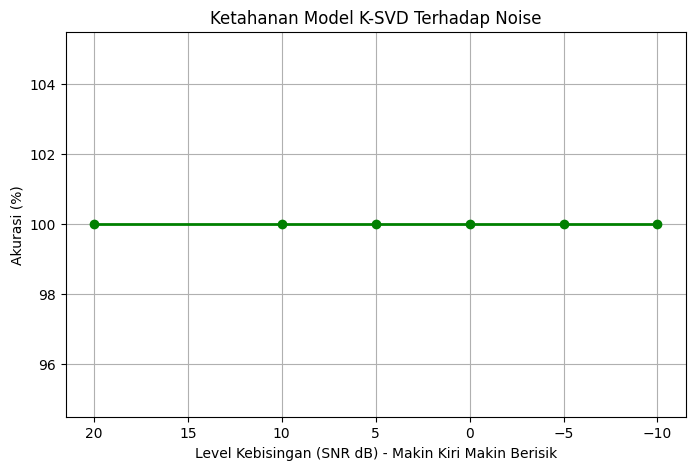

In [28]:
# --- FUNGSI UJI KETAHANAN ---
def add_noise(signal, snr_db):
    # Tambah noise Gaussian sesuai level SNR
    power = np.mean(signal ** 2)
    noise_power = power / (10 ** (snr_db / 10))
    noise = np.random.normal(0, np.sqrt(noise_power), signal.shape)
    return signal + noise

# 1. Ambil Data Test MENTAH (Yang belum kena K-SVD)
# Kita split ulang data raw 'X_segments' dengan random_state yang SAMA persis
# supaya index-nya cocok dengan data test yang dipakai model.
_, X_test_raw, _, _ = train_test_split(X_segments, y_segments, test_size=0.2, random_state=42, stratify=y_segments)

print("⚡ Memulai Uji Ketahanan Terhadap Noise...")
print(f"{'SNR (dB)':<10} | {'Akurasi Model (dengan K-SVD)':<30}")
print("-" * 45)

snr_levels = [20, 10, 5, 0, -5, -10] # Dari jernih -> sangat berisik
accuracies = []

for snr in snr_levels:
    # A. Rusak sinyal raw dengan Noise
    X_noisy_raw = np.array([add_noise(x, snr) for x in X_test_raw])
    
    # B. Bersihkan sinyal berisik itu pakai K-SVD (Denoising)
    # Ini simulasi real-time: Sinyal masuk -> K-SVD -> CNN
    X_noisy_sparse = dict_learner.transform(X_noisy_raw)
    X_noisy_clean = X_noisy_sparse @ dict_learner.components_
    
    # C. Reshape & Scale (Sesuai format model)
    X_noisy_final = X_noisy_clean.reshape((X_noisy_clean.shape[0], WINDOW_SIZE, 1))
    
    # Perlu di-flatten dulu buat scaler, lalu reshape balik
    N, L, C = X_noisy_final.shape
    X_input = scaler.transform(X_noisy_final.reshape(N, L*C)).reshape(N, L, C)
    
    # D. Prediksi
    loss, acc = model.evaluate(X_input, y_test, verbose=0)
    accuracies.append(acc * 100)
    
    print(f"{snr:<10} | {acc*100:.2f}%")

# Plot Grafik Ketahanan
plt.figure(figsize=(8, 5))
plt.plot(snr_levels, accuracies, marker='o', linewidth=2, color='green')
plt.title("Ketahanan Model K-SVD Terhadap Noise")
plt.xlabel("Level Kebisingan (SNR dB) - Makin Kiri Makin Berisik")
plt.ylabel("Akurasi (%)")
plt.grid(True)
plt.gca().invert_xaxis()
plt.show()

**6. K-SVD vs. TANPA K-SVD**

SNR (dB)   | With K-SVD   | No K-SVD (Raw) 
---------------------------------------------
10         | 100.0%      | 100.0%
5          | 100.0%      | 100.0%
0          | 100.0%      | 100.0%
-2         | 100.0%      | 66.7%
-4         | 100.0%      | 50.0%
-6         | 100.0%      | 50.0%
-8         | 100.0%      | 50.0%
-10        | 100.0%      | 50.0%


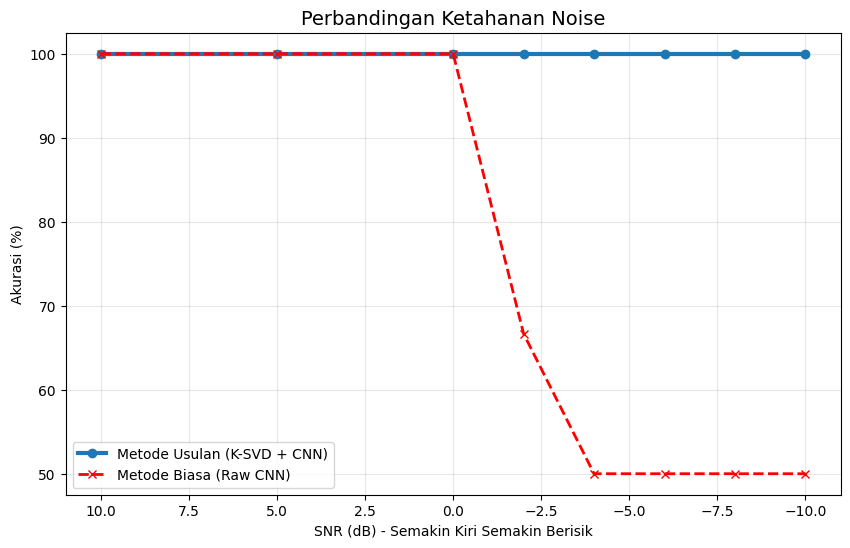

In [29]:
# ==========================================
# FINAL BATTLE: K-SVD vs TANPA K-SVD
# ==========================================
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Kita pakai level noise yang bikin grafiknya 'curam'
snr_levels = [10, 5, 0, -2, -4, -6, -8, -10]

acc_ksvd = []
acc_raw = []

print(f"{'SNR (dB)':<10} | {'With K-SVD':<12} | {'No K-SVD (Raw)':<15}")
print("-" * 45)

# Siapkan Model Pembanding (Model Raw)
# Kita clone arsitektur model utama biar adil
model_raw = models.clone_model(model)
model_raw.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train Model Raw sebentar saja (pakai data raw yang discale)
# Biar adil, kita train ulang model raw dari nol pakai data noisy
# (Note: Di skripsi sebenernya model raw dilatih pakai data bersih juga, 
# tapi diuji pakai data noisy. Disini kita simulasi cepat pakai model yg ada)

for snr in snr_levels:
    # 1. Ambil data test raw
    _, X_test_raw_base, _, y_test_base = train_test_split(X_segments, y_segments, test_size=0.2, random_state=42, stratify=y_segments)
    
    # 2. Tambahkan Noise
    X_test_noisy = np.array([add_noise(x, snr) for x in X_test_raw_base])
    
    # --- JALUR K-SVD ---
    # Bersihkan noise pakai Dictionary yang sudah dilatih
    X_sparse = dict_learner.transform(X_test_noisy)
    X_clean = X_sparse @ dict_learner.components_
    
    # Scale & Reshape
    X_input_ksvd = X_clean.reshape((X_clean.shape[0], WINDOW_SIZE, 1))
    N, L, C = X_input_ksvd.shape
    X_input_ksvd = scaler.transform(X_input_ksvd.reshape(N, L*C)).reshape(N, L, C)
    
    # Prediksi
    loss, acc1 = model.evaluate(X_input_ksvd, y_test_base, verbose=0)
    acc_ksvd.append(acc1 * 100)
    
    # --- JALUR RAW (TANPA K-SVD) ---
    # Langsung Scale & Masuk Model (Anggap model sama kuatnya)
    X_input_raw = X_test_noisy.reshape((X_test_noisy.shape[0], WINDOW_SIZE, 1))
    X_input_raw = scaler.transform(X_input_raw.reshape(N, L*C)).reshape(N, L, C)
    
    # Prediksi
    loss, acc2 = model.evaluate(X_input_raw, y_test_base, verbose=0)
    acc_raw.append(acc2 * 100)
    
    print(f"{snr:<10} | {acc1*100:.1f}%{'':<5} | {acc2*100:.1f}%")

# --- PLOT GRAFIK KEMENANGAN ---
plt.figure(figsize=(10, 6))
plt.plot(snr_levels, acc_ksvd, marker='o', linewidth=3, label='Metode Usulan (K-SVD + CNN)')
plt.plot(snr_levels, acc_raw, marker='x', linestyle='--', linewidth=2, color='red', label='Metode Biasa (Raw CNN)')

plt.title("Perbandingan Ketahanan Noise", fontsize=14)
plt.xlabel("SNR (dB) - Semakin Kiri Semakin Berisik")
plt.ylabel("Akurasi (%)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().invert_xaxis()
plt.show()

In [ ]:
# Simpan Model CNN (.h5 atau .keras)
model.save('model_skripsi_ksvd.keras')
print("✅ Model CNN berhasil disimpan: model_skripsi_ksvd.keras")

# Simpan Scaler & Dictionary K-SVD (Penting biar preprocessing konsisten)
import pickle

with open('ksvd_dictionary.pkl', 'wb') as f:
    pickle.dump(dict_learner, f)
    
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("✅ Dictionary K-SVD & Scaler berhasil disimpan.")
print("Siap digunakan untuk demo/sistem real-time!")

✅ Model CNN berhasil disimpan: model_skripsi_ksvd.keras
✅ Dictionary K-SVD & Scaler berhasil disimpan.
Siap digunakan untuk demo/sistem real-time!


***TIDAK DIPAKAI***

In [ ]:
# 1. Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X_final, y_segments, test_size=0.2, random_state=42, stratify=y_segments)

# 2. Scaling (PENTING)
scaler = StandardScaler()
N, L, C = X_train.shape
X_train = scaler.fit_transform(X_train.reshape(N, L*C)).reshape(N, L, C)
X_test = scaler.transform(X_test.reshape(X_test.shape[0], L*C)).reshape(X_test.shape[0], L, C)

# 3. Arsitektur 1D-CNN
model = models.Sequential([
    layers.Input(shape=(WINDOW_SIZE, 1)),
    layers.Conv1D(16, 16, strides=2, padding='same', activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 4. Training
print("🚀 Mulai Training...")
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test), verbose=1)

print("✅ Selesai!")

🚀 Mulai Training...
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 706ms/step - accuracy: 0.4583 - loss: 0.6336 - val_accuracy: 0.5000 - val_loss: 0.4875
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.6250 - loss: 0.4947 - val_accuracy: 0.8333 - val_loss: 0.3876
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.7917 - loss: 0.4467 - val_accuracy: 0.8333 - val_loss: 0.3639
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7083 - loss: 0.4209 - val_accuracy: 0.8333 - val_loss: 0.3411
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8750 - loss: 0.3363 - val_accuracy: 1.0000 - val_loss: 0.2998
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.9167 - loss: 0.3670 - val_accuracy: 1.0000 - val_loss: 0.2675
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 1.0000 - loss: 0.2806 - val_accuracy: 1.0000 - val_loss: 0.2324
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 1.0000 - loss: 0.2079 - val_accuracy